In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_mnist, load_emnist_letters

In [5]:
# load cifar10 data
trainloader, testloader = load_mnist(data_dir="../data/mnist", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)
# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
from utils import train_valid_split

In [7]:
# load dataloader for steal
stealloader,st_testloader = load_emnist_letters(data_dir="../data/mnist", batch_size=128, train_shuffle=False)

In [8]:
st_trloader, st_valloader = train_valid_split(stealloader,10000,seed=128,datatype="mnist")

total data: 10000


In [86]:
class args:
    save_dir = "../results"
    orig_model = "mnist_orig_mpc.pth"
#     fake_model = "mnist_fake_mpc_minloss_swd.pth"
#     fake_model = "mnist_fake_mpc_minloss.pth"
    fake_model = "mnist_fake_small_mpc_minloss.pth"
    tau = 0.95
#     nb_stolen = 10000 # attack model 학습시 사용할 데이터 수
#     st_trloader = "attnet_trloader.dl"
#     st_valloader = "attnet_valloader.dl"
#     att_epochs = 300
    att_model = "mnist_attacknet_mpc_ml_tau%s.pth"%tau
#     att_model = "mnist_attacknet_mpc_ml_swd_tau%s.pth"%tau

In [87]:
args.att_model

'mnist_attacknet_mpc_ml_tau0.95.pth'

In [90]:
# from cifar_models import Net, Net_logit, AttackNet
from mnist_models import AttackNetMNIST, small_AttackNetMNIST
from utils import CombNet, CombNet_logit, Net_softmax

In [91]:
import os
net = AttackNetMNIST()
net.load_state_dict(torch.load(os.path.join(args.save_dir,args.orig_model),map_location='cpu'))
net = Net_softmax(net)

# net_fake = AttackNetMNIST()
net_fake = small_AttackNetMNIST()
net_fake.load_state_dict(torch.load(os.path.join(args.save_dir,args.fake_model),map_location='cpu'))
net_fake = Net_softmax(net_fake)

comb_net = CombNet(net, net_fake, args.tau)

In [92]:
comb_net.net_orig

Net_softmax(
  (model): AttackNetMNIST(
    (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(5, 50, kernel_size=(5, 5), stride=(2, 2))
    (classifier): Linear(in_features=800, out_features=10, bias=True)
  )
)

In [93]:
from torch.utils.data import TensorDataset, DataLoader
def make_adaptive_loader(model_prob, victim_net, dataloader, tau, device, batch_size=128, shuffle=True):

    model_prob.to(device).eval()
    victim_net.to(device).eval()
    labels = []
    ori_out = []
    with torch.no_grad():
        for x,y in dataloader:
            with torch.no_grad():
                out = victim_net(x.to(device)).detach().cpu()
                ori_out.append(out)
            pred = torch.max(model_prob(x.to(device)).detach().cpu(),axis=1)
#             print(pred)
            labels.append(torch.tensor(pred[0]>tau).float())
            del x,y,pred, out
    data = torch.cat(ori_out,dim=0)
    labels = torch.cat(labels,dim=0)
    dataloader_ = DataLoader(TensorDataset(data, labels),batch_size=batch_size, shuffle=shuffle)
    model_prob.cpu()
    victim_net.cpu()
    return dataloader_
            
    

In [94]:
# attack with true tau for combnet
adpt_trloader = make_adaptive_loader(net, comb_net, st_trloader,comb_net.tau,device, batch_size=128, shuffle=True)
adpt_teloader = make_adaptive_loader(net, comb_net, st_valloader,comb_net.tau,device, batch_size=128, shuffle=False)
adpt_teloader2 = make_adaptive_loader(net, comb_net, testloader,comb_net.tau,device, batch_size=128, shuffle=False)

<ipython-input-93-377d5d037d5f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(pred[0]>tau).float())


In [95]:
from livelossplot import PlotLosses
import torch.nn.functional as F
from utils import test_binary_model
def train_adapt_model(adpt_att_model, adpt_loader, criterion, optimizer, epochs, device, adpt_testloader = None, save_dir = "../results", save_model = "cifar_adapt_model.pth"):
    adpt_att_model.to(device)
    
    logs_clf = {}
    best_acc = 0.0
    liveloss_tr = PlotLosses()
    
    for epoch in range(epochs):
        adpt_att_model.train()
        
        for x,y in adpt_loader:

            adpt_att_model.zero_grad()

            out = adpt_att_model(x.to(device))
            loss = criterion(out.flatten().float(), y.to(device).float())
            
            loss.backward()
            optimizer.step()
            
            del x,out,  y, loss
            torch.cuda.empty_cache()
        logs_clf['loss'], logs_clf['acc']= test_binary_model(adpt_att_model, adpt_loader, criterion, device, 100.0, save_dir, save_model)
        if adpt_testloader is not None:
            logs_clf['val_loss'], logs_clf['val_acc']= test_binary_model(adpt_att_model, adpt_testloader, criterion, device, 0.0, save_dir, save_model)
        liveloss_tr.update(logs_clf)
        liveloss_tr.send()
    adpt_att_model.cpu()
    return adpt_att_model, logs_clf

In [96]:
NUM_CLASSES = 10
class Net_Adapt(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(Net_Adapt, self).__init__()
        self.num_input = num_classes
        self.lin1 = nn.Linear(self.num_input, 128)
        self.lin2 = nn.Linear(128,64)
        self.lin3 = nn.Linear(64,64)
        self.lin4 = nn.Linear(64,1)
    def forward(self,x):
        x = x.view(-1,self.num_input)
        x = F.relu(self.lin1(x))
        x = nn.Dropout(0.3)(x)
        x = F.relu(self.lin2(x))
        x = nn.Dropout(0.2)(x)
        x = F.relu(self.lin3(x))
        x = torch.sigmoid(self.lin4(x)).flatten()
        return x

In [97]:
adpt_att_net = Net_Adapt()
adpt_criterion = nn.BCELoss()
adpt_optimizer = optim.Adam(adpt_att_net.parameters())
adpt_epochs = 100

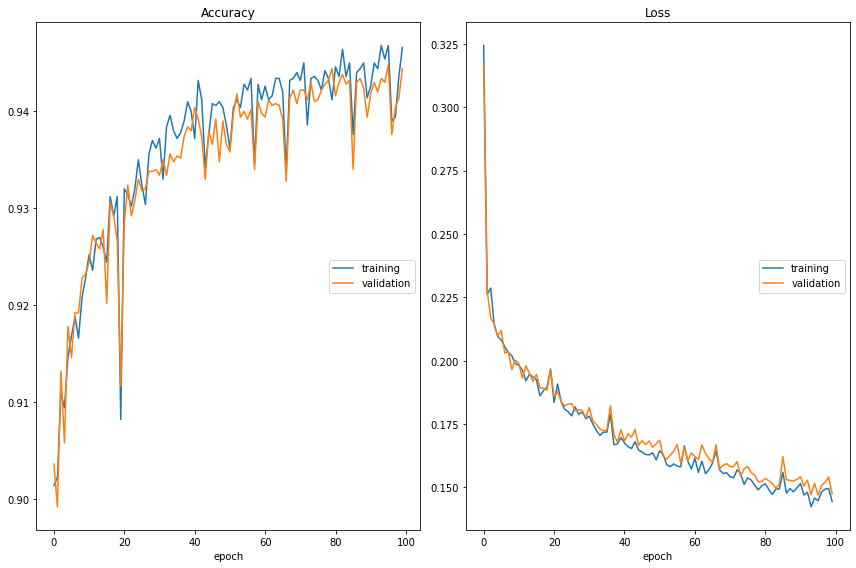

Accuracy
	training         	 (min:    0.901, max:    0.947, cur:    0.947)
	validation       	 (min:    0.899, max:    0.945, cur:    0.944)
Loss
	training         	 (min:    0.142, max:    0.324, cur:    0.144)
	validation       	 (min:    0.147, max:    0.317, cur:    0.147)


In [98]:
adpt_att_net,_ = train_adapt_model(adpt_att_net, adpt_trloader, adpt_criterion, adpt_optimizer, adpt_epochs, device, adpt_teloader)

In [99]:
Xtr = adpt_trloader.dataset.tensors[0]
ytr = adpt_trloader.dataset.tensors[1]
Xte =adpt_teloader.dataset.tensors[0]
yte = adpt_teloader.dataset.tensors[1]
Xte2 =adpt_teloader2.dataset.tensors[0]
yte2 = adpt_teloader2.dataset.tensors[1]


In [100]:
test_binary_model(adpt_att_net, adpt_teloader, adpt_criterion, device, 0.0)

(0.14768575131893158, 0.9458)

In [101]:
def get_prediction(model, testloader, device):
    model.to(device).eval()
    preds = []
    with torch.no_grad():
        for data in testloader:
            preds.append(model(data[0].to(device)).detach().cpu())
        preds = torch.cat(preds,dim=0)
    return preds

In [102]:
from sklearn.metrics import f1_score
preds = get_prediction(adpt_att_net, adpt_teloader,device)
preds_h = (preds>0.5).type(torch.FloatTensor).numpy()
print(f1_score(yte.numpy(), preds_h,pos_label=0))
print(f1_score(yte.numpy(), preds_h,pos_label=1))
# print(f1_score(yte.numpy(), preds_h,average='weighted'))

0.9222741005218347
0.9554961471929548


In [103]:
adpt_att_net

Net_Adapt(
  (lin1): Linear(in_features=10, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=1, bias=True)
)

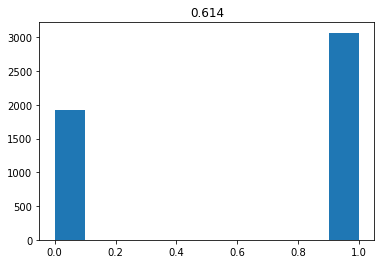

In [104]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(adpt_trloader.dataset.tensors[1].numpy())
plt.title(str(sum(adpt_trloader.dataset.tensors[1].numpy()==1)/len(adpt_trloader.dataset.tensors[1])))
plt.show()

In [105]:
adpt_trloader.dataset.tensors[1]

tensor([0., 0., 1.,  ..., 1., 1., 0.])

In [106]:
test_binary_model(adpt_att_net, adpt_teloader2, adpt_criterion, device, 0.0)

(0.5211088061332703, 0.8738)

In [107]:
from sklearn.metrics import f1_score
preds2 = get_prediction(adpt_att_net, adpt_teloader2,device)
preds_h2 = (preds2>0.5).type(torch.FloatTensor).numpy()
print(f1_score(yte2.numpy(), preds_h2,pos_label=0))
print(f1_score(yte2.numpy(), preds_h2,pos_label=1))
# print(f1_score(yte.numpy(), preds_h,average='weighted'))

0.25742574257425743
0.9302630859268174


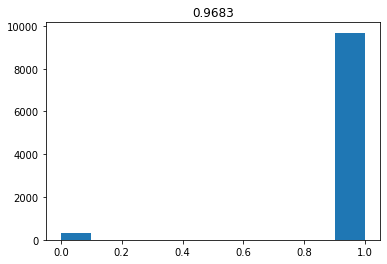

In [108]:
import matplotlib.pyplot as plt
ys = adpt_teloader2.dataset.tensors[1].numpy()
plt.figure()
plt.hist(ys)
plt.title(str(sum(ys==1)/len(ys)))
plt.show()

In [109]:
from utils import test_model
loss = nn.CrossEntropyLoss()
test_model(comb_net.to(device),testloader,loss,device)

(tensor(1.4964), tensor(96.5200))

In [85]:
test_model(net.to(device),testloader,loss,device)

(tensor(1.4761), tensor(98.6900))

In [110]:
for tau in [0.9,0.95,0.99,0.995,0.999,0.9995]:
    comb_net = CombNet(net, net_fake, tau)
    print(test_model(comb_net.to(device),testloader,loss,device))

(tensor(1.4892), tensor(97.2800))
(tensor(1.4964), tensor(96.5200))
(tensor(1.5190), tensor(94.2000))
(tensor(1.5316), tensor(92.9200))
(tensor(1.5771), tensor(88.3300))
(tensor(1.6036), tensor(85.6600))
